### **Import HF transformer pipeline**

In [8]:

from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


In [9]:
PIXEL_SIZE_UM = 0.5  # Change this to match your calibration

def calculate_grain_areas(masks, pixel_size_um=PIXEL_SIZE_UM):
    """Calculate area and basic metrics for each mask"""
    grain_data = []

    for i, mask in enumerate(masks):
        if len(mask.shape) > 2:
            mask_2d = mask.reshape(mask.shape[-2], mask.shape[-1])
        else:
            mask_2d = mask

        area_pixels = np.sum(mask_2d > 0)
        area_um2 = area_pixels * (pixel_size_um ** 2)

        if area_pixels > 50:
            diameter_um = 2 * np.sqrt(area_um2 / np.pi)

            moments = cv2.moments(mask_2d.astype(np.uint8))
            if moments['m00'] != 0:
                cx = int(moments['m10'] / moments['m00'])
                cy = int(moments['m01'] / moments['m00'])
            else:
                cx, cy = 0, 0

            grain_data.append({
                'grain_id': i + 1,
                'area_pixels': area_pixels,
                'area_um2': area_um2,
                'diameter_um': diameter_um,
                'centroid_x': cx,
                'centroid_y': cy
            })

    return grain_data

def get_statistics(grain_data):
    """Calculate summary statistics"""
    if not grain_data:
        return {}

    areas = [g['area_um2'] for g in grain_data]
    diameters = [g['diameter_um'] for g in grain_data]

    stats = {
        'total_grains': len(grain_data),
        'total_area_um2': sum(areas),
        'mean_area_um2': np.mean(areas),
        'std_area_um2': np.std(areas),
        'min_area_um2': min(areas),
        'max_area_um2': max(areas),
        'mean_diameter_um': np.mean(diameters),
        'std_diameter_um': np.std(diameters)
    }
    return stats

def show_mask(mask, ax, random_color=False, grain_info=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    if grain_info:
        cx, cy = grain_info['centroid_x'], grain_info['centroid_y']
        area = grain_info['area_um2']
        ax.text(cx, cy, f'{area:.0f}μm²', ha='center', va='center',
                fontsize=6, color='white', weight='bold',
                bbox=dict(boxstyle="round,pad=0.1", facecolor='black', alpha=0.7))

    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks, path, pixel_size_um=PIXEL_SIZE_UM):
    grain_data = calculate_grain_areas(masks, pixel_size_um)
    stats = get_statistics(grain_data)

    plt.figure(figsize=(12, 8))
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)

    for i, mask in enumerate(masks):
        grain_info = None
        for grain in grain_data:
            if grain['grain_id'] == i + 1:
                grain_info = grain
                break

        show_mask(mask, ax=ax, random_color=True, grain_info=grain_info)

    if stats:
        title = f"Grains: {stats['total_grains']}, Mean area: {stats['mean_area_um2']:.1f}±{stats['std_area_um2']:.1f} μm²"
        plt.title(title, fontsize=10, pad=10)

    basename = os.path.basename(path)
    name = os.path.splitext(basename)[0]
    plt.axis("off")
    fn = os.path.join('/content/masked_n1/', name + "_with_areas.png")
    plt.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

    if stats:
        print(f"\n--- {name} Analysis ---")
        print(f"Total grains: {stats['total_grains']}")
        print(f"Mean area: {stats['mean_area_um2']:.1f} ± {stats['std_area_um2']:.1f} μm²")
        print(f"Area range: {stats['min_area_um2']:.1f} - {stats['max_area_um2']:.1f} μm²")
        print(f"Mean diameter: {stats['mean_diameter_um']:.1f} ± {stats['std_diameter_um']:.1f} μm")

    if grain_data:
        csv_path = os.path.join('/content/masked_n1/', name + "_grain_data.csv")
        df = pd.DataFrame(grain_data)
        df.to_csv(csv_path, index=False)
        print(f"Grain data saved: {csv_path}")

    del mask
    gc.collect()

    return grain_data, stats


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gc
from numba import jit
import cv2
import os
import pandas as pd
from PIL import Image
import gc
from imutils import paths
import os
%matplotlib inline

Processing 8 images with pixel size: 0.5 μm/pixel

Processing batch 1: 4 images


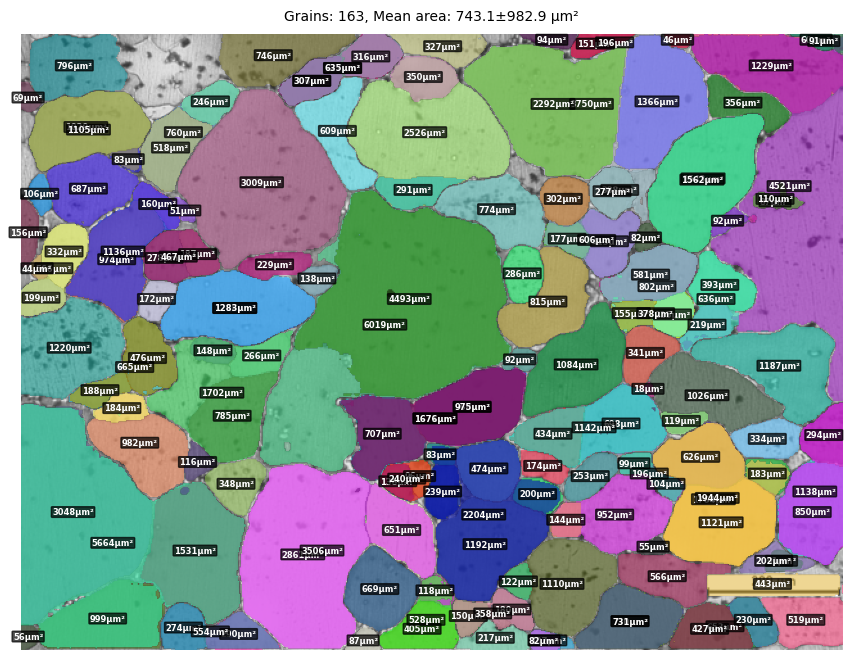


--- image0002 Analysis ---
Total grains: 163
Mean area: 743.1 ± 982.9 μm²
Area range: 18.5 - 6019.2 μm²
Mean diameter: 26.4 ± 15.7 μm
Grain data saved: /content/masked_n1/image0002_grain_data.csv


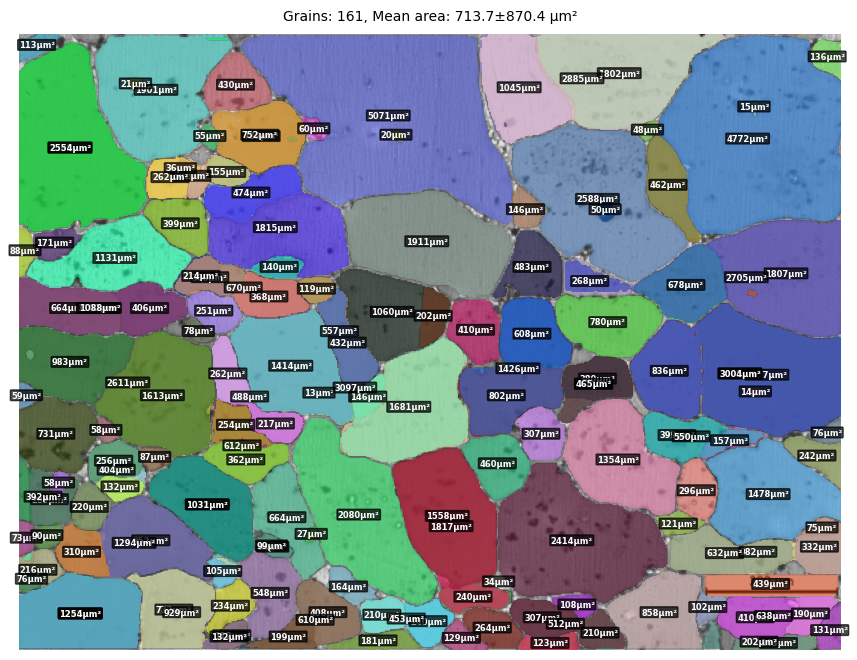


--- image0006 Analysis ---
Total grains: 161
Mean area: 713.7 ± 870.4 μm²
Area range: 12.8 - 5070.8 μm²
Mean diameter: 25.8 ± 15.6 μm
Grain data saved: /content/masked_n1/image0006_grain_data.csv


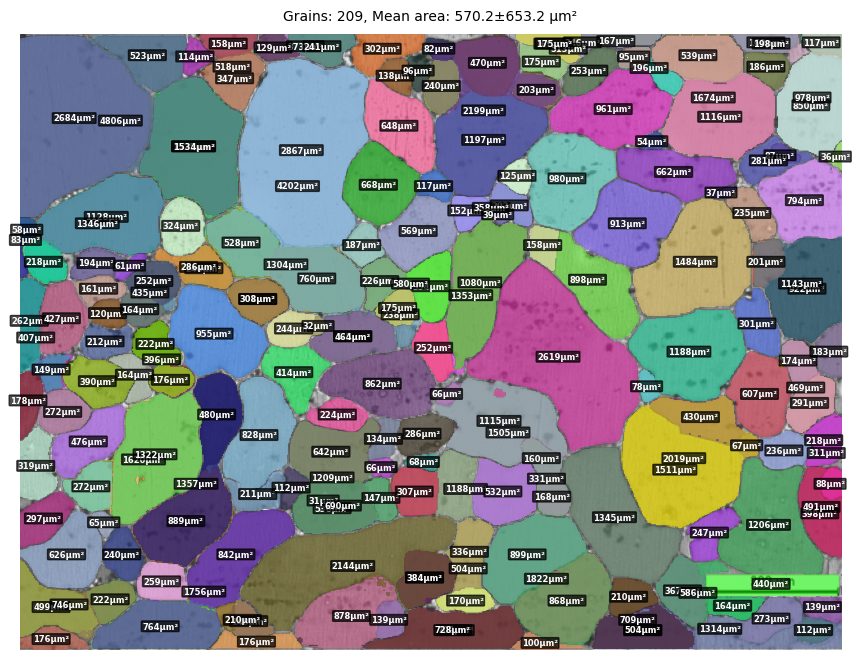


--- image0003 Analysis ---
Total grains: 209
Mean area: 570.2 ± 653.2 μm²
Area range: 31.0 - 4805.8 μm²
Mean diameter: 23.9 ± 12.4 μm
Grain data saved: /content/masked_n1/image0003_grain_data.csv


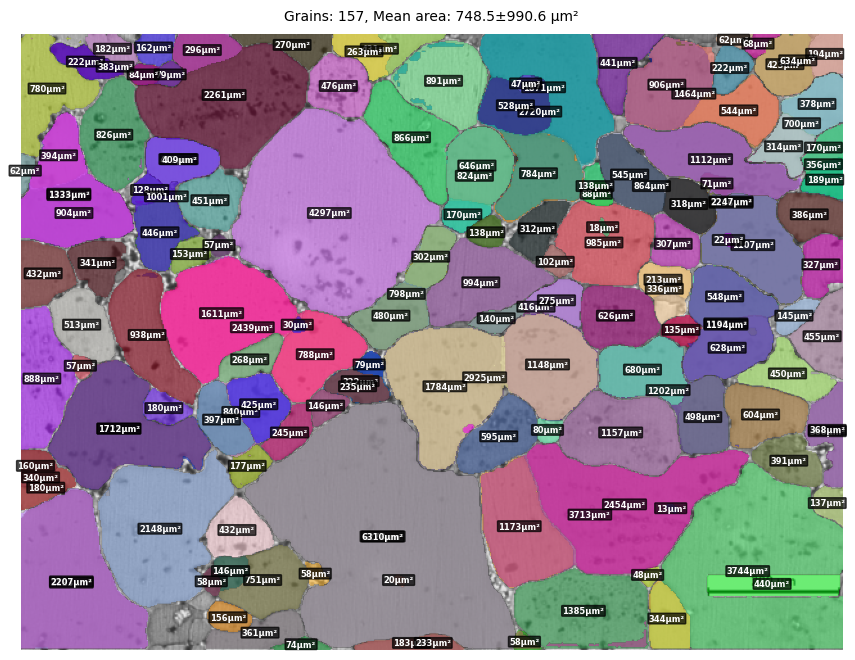


--- image0005 Analysis ---
Total grains: 157
Mean area: 748.5 ± 990.6 μm²
Area range: 13.2 - 6310.0 μm²
Mean diameter: 26.5 ± 15.9 μm
Grain data saved: /content/masked_n1/image0005_grain_data.csv

Processing batch 2: 4 images


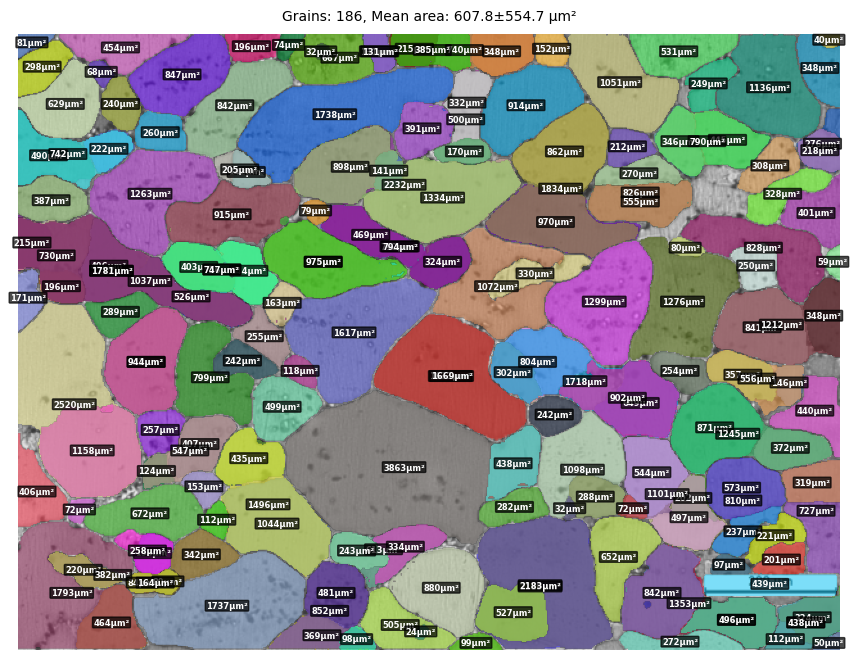


--- image0004 Analysis ---
Total grains: 186
Mean area: 607.8 ± 554.7 μm²
Area range: 24.0 - 3863.0 μm²
Mean diameter: 25.4 ± 11.4 μm
Grain data saved: /content/masked_n1/image0004_grain_data.csv


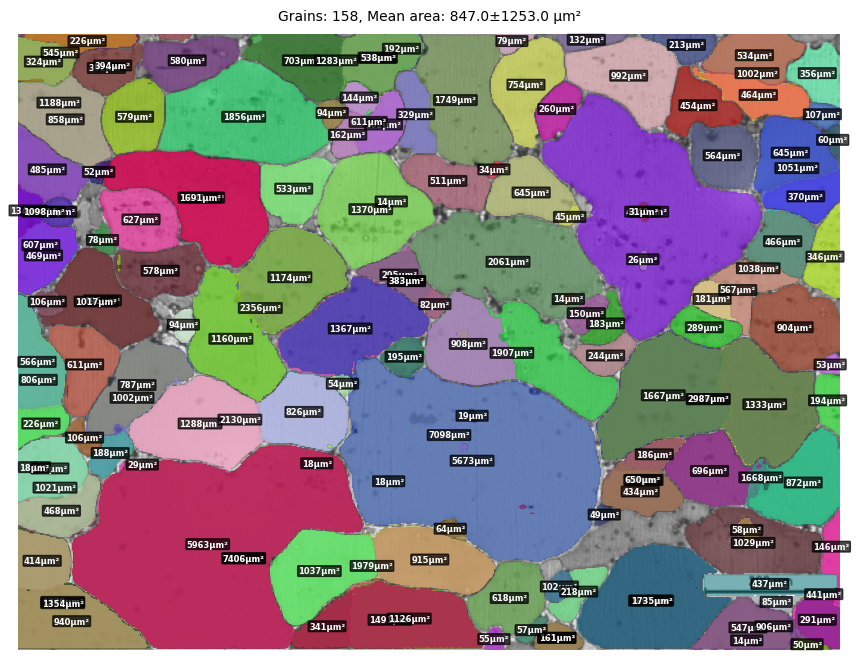


--- image0008 Analysis ---
Total grains: 158
Mean area: 847.0 ± 1253.0 μm²
Area range: 13.5 - 7408.5 μm²
Mean diameter: 27.5 ± 18.0 μm
Grain data saved: /content/masked_n1/image0008_grain_data.csv


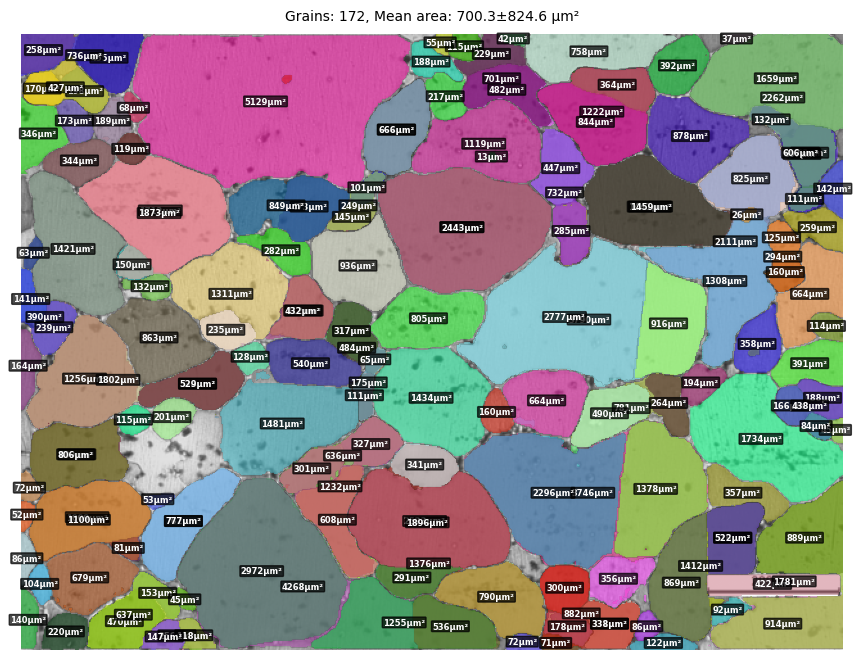


--- image0001 Analysis ---
Total grains: 172
Mean area: 700.3 ± 824.6 μm²
Area range: 12.8 - 5129.2 μm²
Mean diameter: 26.0 ± 14.7 μm
Grain data saved: /content/masked_n1/image0001_grain_data.csv


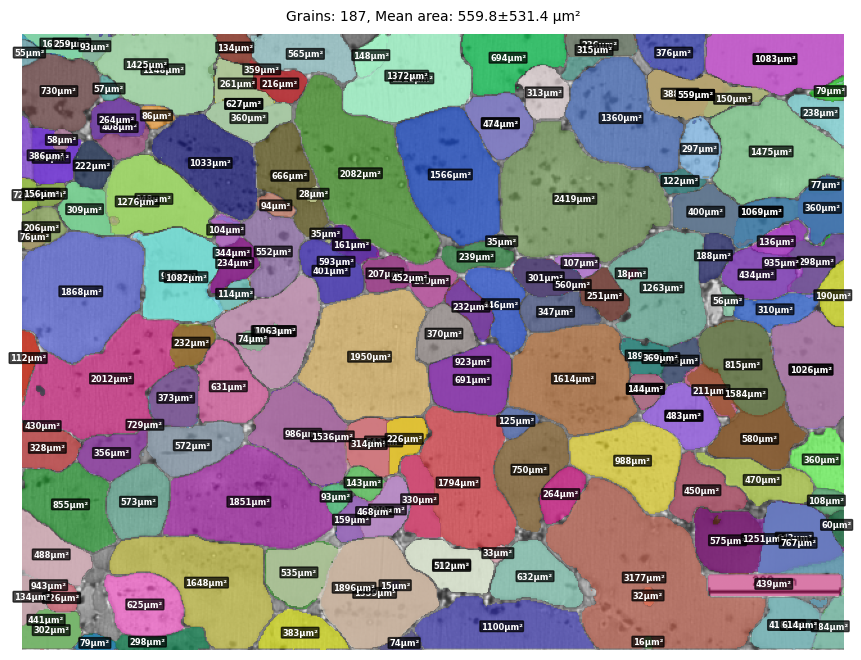


--- image0007 Analysis ---
Total grains: 187
Mean area: 559.8 ± 531.4 μm²
Area range: 14.8 - 3177.0 μm²
Mean diameter: 24.0 ± 11.7 μm
Grain data saved: /content/masked_n1/image0007_grain_data.csv


In [11]:
# omit with your path
if not os.path.exists('/content/masked_n1'):
    os.makedirs('/content/masked_n1')

image_paths = list(paths.list_images('/content/data/')) # omit with your path

batch_size = 4

all_results = []

print(f"Processing {len(image_paths)} images with pixel size: {PIXEL_SIZE_UM} μm/pixel")
print("=" * 60)

for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    print(f"\nProcessing batch {i//batch_size + 1}: {len(batch_paths)} images")

    batch_images = []
    for imagepath in batch_paths:
        raw_image = Image.open(imagepath).convert("RGB")
        new_image = raw_image.resize((640, 480))
        batch_images.append(new_image)

    outputs = generator(batch_images, points_per_batch=64)

    for imagepath, new_image, output in zip(batch_paths, batch_images, outputs):
        masks = output["masks"]
        grain_data, stats = show_masks_on_image(new_image, masks, imagepath)

        result = {
            'image_name': os.path.basename(imagepath),
            'grain_data': grain_data,
            'stats': stats
        }
        all_results.append(result)

    gc.collect()


In [12]:
print("\n" + "=" * 60)
print("BATCH SUMMARY")
print("=" * 60)

all_grain_data = []
image_summaries = []

for result in all_results:
    if result['grain_data']:
        for grain in result['grain_data']:
            grain_with_image = grain.copy()
            grain_with_image['image_name'] = result['image_name']
            all_grain_data.append(grain_with_image)

        stats = result['stats']
        image_summaries.append({
            'image_name': result['image_name'],
            'num_grains': stats['total_grains'],
            'mean_area_um2': stats['mean_area_um2'],
            'total_area_um2': stats['total_area_um2']
        })

if all_grain_data:
    all_df = pd.DataFrame(all_grain_data)
    all_df.to_csv('/content/masked_n1/ALL_GRAINS_COMBINED.csv', index=False)

    summary_df = pd.DataFrame(image_summaries)
    summary_df.to_csv('/content/masked_n1/IMAGE_SUMMARIES.csv', index=False)

    all_areas = all_df['area_um2'].values
    print(f"OVERALL STATISTICS:")
    print(f"Total images processed: {len(all_results)}")
    print(f"Total grains found: {len(all_grain_data)}")
    print(f"Overall mean area: {np.mean(all_areas):.1f} ± {np.std(all_areas):.1f} μm²")
    print(f"Overall area range: {np.min(all_areas):.1f} - {np.max(all_areas):.1f} μm²")
    print(f"Median area: {np.median(all_areas):.1f} μm²")

    print(f"\nFiles saved:")
    print(f"- Individual images with areas: /content/masked_n1/*_with_areas.png")
    print(f"- Individual grain data: /content/masked_n1/*_grain_data.csv")
    print(f"- Combined grain data: /content/masked_n1/ALL_GRAINS_COMBINED.csv")
    print(f"- Image summaries: /content/masked_n1/IMAGE_SUMMARIES.csv")

print(f"\nDone! Check /content/masked/ folder for results.")


BATCH SUMMARY
OVERALL STATISTICS:
Total images processed: 8
Total grains found: 1393
Overall mean area: 678.2 ± 851.5 μm²
Overall area range: 12.8 - 7408.5 μm²
Median area: 399.0 μm²

Files saved:
- Individual images with areas: /content/masked_n1/*_with_areas.png
- Individual grain data: /content/masked_n1/*_grain_data.csv
- Combined grain data: /content/masked_n1/ALL_GRAINS_COMBINED.csv
- Image summaries: /content/masked_n1/IMAGE_SUMMARIES.csv

Done! Check /content/masked/ folder for results.


### **You can run the cell below to download the image output**

In [13]:
!zip -r /content/file.zip /output_image_path/

	zip warning: name not matched: /output_image_path/

zip error: Nothing to do! (try: zip -r /content/file.zip . -i /output_image_path/)
